## CURVETOPIA: A Journey into the World of Curves

### Problem Statement
The goal of the CURVETOPIA project is to identify, regularize, and beautify curves in 2D Euclidean space. This involves detecting different types of shapes (such as circles, rectangles, and general curves) from hand-drawn images, and regularizing them to their ideal geometric forms. The challenge is to accurately transform these distorted, hand-drawn shapes into smooth, well-defined curves.


## Approach 1: Initial Implementation

### Methodology
1. **Circle Detection:** Applied least squares fitting to detect and regularize circles.
2. **Rectangle Detection:** Implemented corner detection to identify and regularize rectangles.
3. **Curve Fitting:** Used cubic B-splines to smooth out the curves.




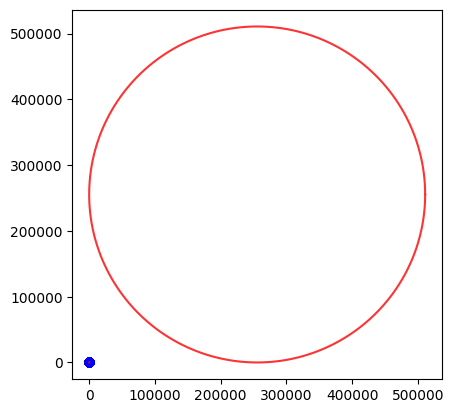

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev

def fit_circle(points):
    def calc_radius(xc, yc, x, y):
        return np.sqrt((x - xc)**2 + (y - yc)**2)

    def residuals(c, x, y):
        Ri = calc_radius(c[0], c[1], x, y)
        return Ri - Ri.mean()

    x = points[:, 0]
    y = points[:, 1]
    x_m, y_m = np.mean(x), np.mean(y)
    initial_guess = [x_m, y_m]

    opt_result = least_squares(residuals, initial_guess, args=(x, y))
    x_c, y_c = opt_result.x

    R = calc_radius(x_c, y_c, x, y).mean()
    theta = np.linspace(0, 2 * np.pi, 200)  # Ensure a smooth circle

    x_reg = x_c + R * np.cos(theta)
    y_reg = x_c + R * np.sin(theta)

    return np.column_stack((x_reg, y_reg))

def fit_spline(points):
    tck, u = splprep([points[:, 0], points[:, 1]], s=0.5, k=3)  # Adjusted smoothing factor
    u_fine = np.linspace(0, 1, len(points) * 20)  # More points for smoother spline
    x_fine, y_fine = splev(u_fine, tck)
    return np.column_stack((x_fine, y_fine))

def is_circle(points, tolerance=10):
    if len(points) < 5:
        return False
    center_guess = np.mean(points, axis=0)
    distances = np.linalg.norm(points - center_guess, axis=1)
    return np.std(distances) < tolerance

def is_rectangle(points, tolerance=1e-2):
    if len(points) != 4:
        return False
    dists = np.linalg.norm(points - np.roll(points, -1, axis=0), axis=1)
    return np.allclose(dists[0], dists[2], atol=tolerance) and np.allclose(dists[1], dists[3], atol=tolerance)

def regularize_rectangle(points):
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])

    rect_points = np.array([
        [x_min, y_min],
        [x_max, y_min],
        [x_max, y_max],
        [x_min, y_max],
        [x_min, y_min]  # Close the loop
    ])
    return rect_points

def regularize_shape(fragment):
    if is_circle(fragment):
        return fit_circle(fragment)
    elif is_rectangle(fragment):
        return regularize_rectangle(fragment)
    else:
        return fit_spline(fragment)  # Treat as a spline curve

def process_shapes(path_XYs):
    regularized_fragments = []
    for fragment in path_XYs:
        try:
            regularized_shape = regularize_shape(fragment)
        except Exception as e:
            print(f"Failed to regularize shape: {e}")
            regularized_shape = fragment  # If regularization fails, keep the original
        regularized_fragments.append(regularized_shape)
    return regularized_fragments

def plot_regularized_fragments(original_fragments, regularized_fragments):
    fig, ax = plt.subplots()
    for orig, reg in zip(original_fragments, regularized_fragments):
        ax.plot(orig[:, 0], orig[:, 1], 'bo-', alpha=0.3)  # Original
        ax.plot(reg[:, 0], reg[:, 1], 'r-', alpha=0.8)  # Regularized

    ax.set_aspect('equal', 'box')
    plt.show()

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        path_XYs.append(npXYs)
    return path_XYs

# Example usage
csv_path = r'assets/frag0.csv'  # Replace with your actual file path
path_XYs = read_csv(csv_path)
regularized_fragments = process_shapes(path_XYs)
plot_regularized_fragments(path_XYs, regularized_fragments)



### Challenges Encountered
- The initial approach struggled with detecting and correctly regularizing shapes due to noise in the data and issues with scale.
- The regularization did not always produce the desired geometric shapes, leading to incorrect results.

## Approach 2: Proximity-Based Grouping

### Methodology
### Methodology
1. **Edge Detection:** Uses GaussianBlur and Canny edge detection to identify edges in the image.
2. **Contour Approximation:** Applies cv2.approxPolyDP to approximate contours to polygons.
3. **Shape Regularization:** Fits contours to regular shapes, such as circles or polygons, using functions like cv2.minEnclosingCircle and cv2.drawContours.


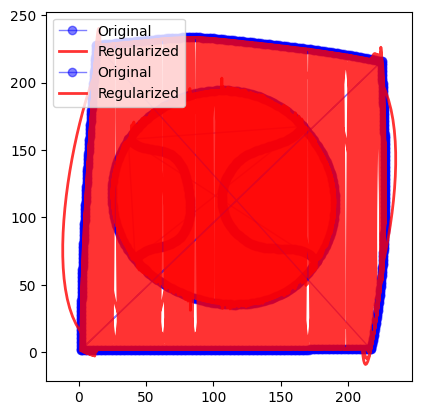

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev

# Function to read the CSV file
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    return np_path_XYs[:, 2:]  # Focus on x and y coordinates only

# Function to apply DBSCAN clustering for proximity-based grouping
def proximity_based_grouping(data, eps=10, min_samples=3):
    # Use DBSCAN to group points that are close to each other
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = clustering.labels_

    grouped_fragments = []
    for label in np.unique(labels):
        if label == -1:  # Ignore noise points
            continue
        grouped_fragments.append(data[labels == label])

    return grouped_fragments

# Function to fit a circle
def fit_circle(points):
    def calc_radius(xc, yc, x, y):
        return np.sqrt((x - xc)**2 + (y - yc)**2)

    def residuals(c, x, y):
        Ri = calc_radius(c[0], c[1], x, y)
        return Ri - Ri.mean()

    x = points[:, 0]
    y = points[:, 1]
    x_m, y_m = np.mean(x), np.mean(y)
    initial_guess = [x_m, y_m]

    opt_result = least_squares(residuals, initial_guess, args=(x, y))
    x_c, y_c = opt_result.x

    R = calc_radius(x_c, y_c, x, y).mean()
    theta = np.linspace(0, 2 * np.pi, 200)  # Ensure a smooth circle

    x_reg = x_c + R * np.cos(theta)
    y_reg = x_c + R * np.sin(theta)

    return np.column_stack((x_reg, y_reg))

# Function to fit a spline
def fit_spline(points):
    if len(points) < 4:  # Not enough points for a cubic spline
        return points  # Return the points as-is

    # Remove duplicate points
    unique_points = np.unique(points, axis=0)
    
    if len(unique_points) < 4:  # Not enough unique points
        return unique_points  # Return the unique points as-is

    try:
        tck, u = splprep([unique_points[:, 0], unique_points[:, 1]], s=0.5, k=3)  # Adjusted smoothing factor
        u_fine = np.linspace(0, 1, len(unique_points) * 20)  # More points for smoother spline
        x_fine, y_fine = splev(u_fine, tck)
        return np.column_stack((x_fine, y_fine))
    except ValueError as e:
        print(f"Error fitting spline: {e}")
        return unique_points  # Fallback: return the unique points


# Function to detect if the shape is a circle
def is_circle(points, tolerance=10):
    if len(points) < 5:
        return False
    center_guess = np.mean(points, axis=0)
    distances = np.linalg.norm(points - center_guess, axis=1)
    return np.std(distances) < tolerance

# Function to detect if the shape is a rectangle
def is_rectangle(points, tolerance=1e-2):
    if len(points) != 4:
        return False
    dists = np.linalg.norm(points - np.roll(points, -1, axis=0), axis=1)
    return np.allclose(dists[0], dists[2], atol=tolerance) and np.allclose(dists[1], dists[3], atol=tolerance)

# Function to regularize a rectangle
def regularize_rectangle(points):
    x_min, x_max = np.min(points[:, 0]), np.max(points[:, 0])
    y_min, y_max = np.min(points[:, 1]), np.max(points[:, 1])

    rect_points = np.array([
        [x_min, y_min],
        [x_max, y_min],
        [x_max, y_max],
        [x_min, y_max],
        [x_min, y_min]  # Close the loop
    ])
    return rect_points

# Function to regularize a shape based on its type
def regularize_shape(fragment):
    if is_circle(fragment):
        return fit_circle(fragment)
    elif is_rectangle(fragment):
        return regularize_rectangle(fragment)
    else:
        return fit_spline(fragment)  # Treat as a spline curve

# Function to process and regularize the grouped shapes
def regularize_grouped_shapes(grouped_fragments):
    regularized_fragments = []
    for fragment in grouped_fragments:
        regularized_fragments.append(regularize_shape(fragment))
    return regularized_fragments

# Function to plot the original and regularized fragments
def plot_regularized_fragments(original_fragments, regularized_fragments):
    fig, ax = plt.subplots()
    
    for orig, reg in zip(original_fragments, regularized_fragments):
        ax.plot(orig[:, 0], orig[:, 1], 'bo-', alpha=0.5, label='Original', linewidth=1)  # Original in blue
        ax.plot(reg[:, 0], reg[:, 1], 'r-', alpha=0.8, label='Regularized', linewidth=2)  # Regularized in red
    
    ax.set_aspect('equal', 'box')
    plt.legend()
    plt.show()


# Example usage
csv_path = r'assets/frag0.csv'  # Replace with your actual file path
data = read_csv(csv_path)
grouped_fragments = proximity_based_grouping(data)
regularized_fragments = regularize_grouped_shapes(grouped_fragments)
plot_regularized_fragments(grouped_fragments, regularized_fragments)


### Issues Encountered
- Clustering sometimes resulted in too few points for effective regularization, especially for spline fitting.
- The method required fine-tuning of parameters to avoid over- or under-segmentation of shapes.


## Approach 3: OpenCv 

### Methodology
1. **Proximity-Based Grouping:** Used DBSCAN clustering to group nearby points, assuming they belong to the same shape.
2. **Shape-Specific Regularization:** Applied different regularization techniques based on the detected shape (circle, rectangle, or curve).


In [20]:
import numpy as np
import cv2

def paths_to_image(paths_XYs, image_size=(512, 512)):
    image = np.zeros(image_size, dtype=np.uint8)
    for XYs in paths_XYs:
        for XY in XYs:
            for i in range(len(XY) - 1):
                start_point = tuple(XY[i].astype(int))
                end_point = tuple(XY[i + 1].astype(int))
                cv2.line(image, start_point, end_point, 255, 1)
    return image

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Example usage
csv_file_path = r'assets/frag0.csv'
paths_XYs = read_csv(csv_file_path)
image = paths_to_image(paths_XYs)
output_image_path = 'output_image.png'
cv2.imwrite(output_image_path, image)

# Display the image using an external viewer
import os
# os.system(f'xdg-open {output_image_path}')  # For Linux
# os.system(f'open {output_image_path}')  # For MacOS
os.system(f'start {output_image_path}')  # For Windows

0

In [21]:
def detect_lines(image):
    edges = cv2.Canny(image, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=50)
    return lines

# Example usage
lines = detect_lines(image)
line_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored lines

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 1)  # Draw in blue
output_image_path = 'line.png'
cv2.imwrite(output_image_path, line_image)

# Display the image using an external viewer
import os
# os.system(f'xdg-open {output_image_path}')  # For Linux
# os.system(f'open {output_image_path}')  # For MacOS
os.system(f'start {output_image_path}')  # For Windows


0

In [22]:
import numpy as np
import cv2

def detect_circles(image):
    # Preprocess the image: Apply GaussianBlur and Canny edge detection
    blurred = cv2.GaussianBlur(image, (9, 9), 2)
    edges = cv2.Canny(image, 50, 150, apertureSize=3)

    # Detect circles using Hough Circle Transform
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1.5, minDist=450,
                               param1=100, param2=30, minRadius=0, maxRadius=0)
    return circles

# Example usage
circles = detect_circles(image)
circle_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored circles

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(circle_image, (x, y), r, (255, 0, 0), 2)  # Draw in red

output_image_path = 'circle_detected.png'
cv2.imwrite(output_image_path, circle_image)

# Display the image using an external viewer
import os
os.system(f'start {output_image_path}')  # For Windows


0

In [23]:
import cv2
import numpy as np

# Read the input image
circle_image1 = cv2.imread('circle.png')

# Convert to grayscale
gray = cv2.cvtColor(circle_image1, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding
adaptive_thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Apply morphological operations to enhance the edges
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
morph = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)

# Detect edges using Canny
edges = cv2.Canny(morph, 50, 150)

# Find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop through the contours to find ellipses
for contour in contours:
    if len(contour) >= 5:  # fitEllipse requires at least 5 points
        area = cv2.contourArea(contour)
        if area > 100:  # Filter out small contours
            # Fit an ellipse to the contour
            ellipse = cv2.fitEllipse(contour)
            (center, axes, orientation) = ellipse
            center = (int(center[0]), int(center[1]))
            axes = (int(axes[0] / 2), int(axes[1] / 2))  # Divide by 2 to get the semi-major and semi-minor axes
            orientation = int(orientation)

            # Calculate aspect ratio
            aspect_ratio = min(axes) / max(axes)

            # Apply stricter criteria for circularity
            circularity = 4 * np.pi * area / (cv2.arcLength(contour, True) ** 2)
            if 0.9 <= aspect_ratio <= 1.1 and circularity > 0.79:  # Adjust threshold as needed
                cv2.ellipse(circle_image1, ellipse, (0, 255, 0), 2)

# Save the output image
output_image_path = 'circle_detected1.png'
cv2.imwrite(output_image_path, circle_image1)


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


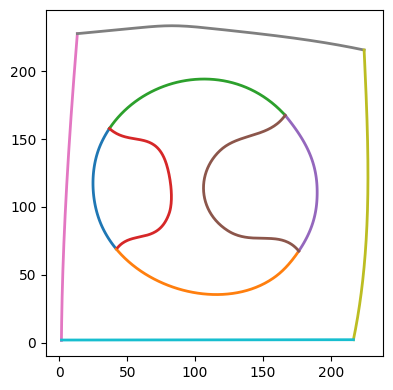

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot_paths(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(4,4))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()


csv_file_path = r'assets/frag0.csv' 

paths_XYs = read_csv(csv_file_path)
plot_paths(paths_XYs)

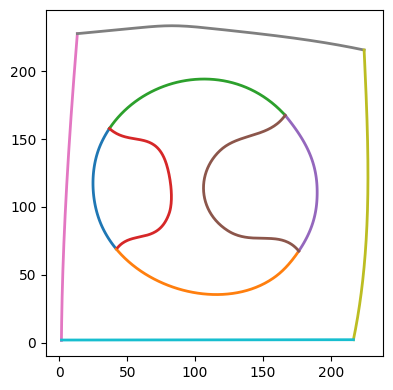

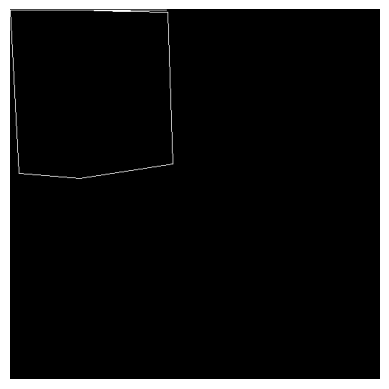

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot_paths(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(4,4))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2)
    ax.set_aspect('equal')
    plt.show()

def paths_to_image(paths_XYs, image_size=(512, 512)):
    image = np.zeros(image_size, dtype=np.uint8)
    for XYs in paths_XYs:
        for XY in XYs:
            for i in range(len(XY) - 1):
                start_point = tuple(XY[i].astype(int))
                end_point = tuple(XY[i + 1].astype(int))
                cv2.line(image, start_point, end_point, 255, 1)
    return image

def detect_and_regularize_shapes(image):
    # Edge detection
    edges = cv2.Canny(image, 50, 150)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    regularized_image = np.zeros_like(image)
    
    for contour in contours:
        # Approximate contour to polygon
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Fit the polygon to a circle
        if len(approx) > 8:
            (x, y), radius = cv2.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            cv2.circle(regularized_image, center, radius, 255, 1)
        else:
            # Draw the approximated polygon
            cv2.drawContours(regularized_image, [approx], 0, 255, 1)
    
    return regularized_image

def plot_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

csv_file_path = r'assets/frag0.csv'

# Read and plot original paths
paths_XYs = read_csv(csv_file_path)
plot_paths(paths_XYs)

# Convert paths to image
image = paths_to_image(paths_XYs)

# Detect and regularize shapes
regularized_image = detect_and_regularize_shapes(image)

# Plot regularized shapes
plot_image(regularized_image)


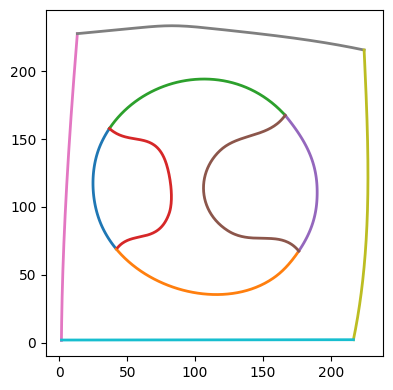

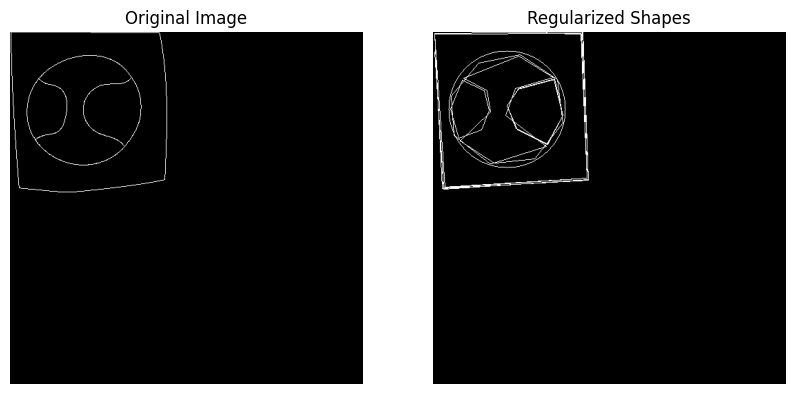

In [ ]:

paths_XYs = read_csv(csv_file_path)
plot_paths(paths_XYs)


image = paths_to_image(paths_XYs)

# image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

# Apply GaussianBlur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Edge detection
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty image for regularized shapes
regularized_image = np.zeros_like(image)

# Define a function to fit and draw regular shapes
def fit_and_draw_shape(contour, output_image):
    # Approximate contour to polygon
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    # Fit the polygon to a circle if it has many vertices
    if len(approx) > 10:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(output_image, center, radius, 255, 1)
    else:
        # Draw the approximated polygon
        cv2.drawContours(output_image, [approx], 0, 255, 1)

# Process each contour
for contour in contours:
    fit_and_draw_shape(contour, regularized_image)

# Plot original image and regularized shapes
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(regularized_image, cmap='gray')
axs[1].set_title('Regularized Shapes')
axs[1].axis('off')

plt.show()


### Issues Encountered
- This appears was not accurate with shape identification.
- The method required too mch fine-tuning of parameters which was impractical.


## Unexplored Approaches - CGAL

We could also solve this problem using the CGAL library, it has algorithms that can help us fit smooth curves to a series of points, identify and clean up common shapes like circles or rectangles, and find symmetrical patterns. It can also help in fixing broken shapes by filling in missing parts. By using CGAL, we can automate the process of turning rough or incomplete drawings into smooth, regular curves, making the final output look clean and polished.

Due to time constraints we couldnt explored this approach.